<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Create-pycortex-vertex-objects" data-toc-modified-id="Create-pycortex-vertex-objects-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create pycortex vertex objects</a></span></li><li><span><a href="#Create-figures-etc" data-toc-modified-id="Create-figures-etc-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create figures etc</a></span></li></ul></div>

In [1]:
import cortex as cx
import platform
from pathlib import Path
import json
import nilearn.surface as surface
import pandas as pd
import numpy as np
import glob
import os, shutil, shlex, subprocess
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb, rgb2hex
from matplotlib import cm
from matplotlib.widgets import Slider
import seaborn as sns
# needs prfpy for prf spatial plot, and for model predictions at some point
from prfpy.rf import gauss2D_iso_cart
from prfpy.model import Iso2DGaussianModel
from prf_expect.utils import io
from prf_expect.utils.fit import PRFModel, Parameters
from nilearn.glm.first_level.hemodynamic_models import _gamma_difference_hrf
from nilearn.glm.first_level.hemodynamic_models import (
    spm_hrf,
    spm_time_derivative,
    spm_dispersion_derivative,
)

In [2]:
from shutil import which
print(which("inkscape"))
os.system('inkscape --version')

None


sh: inkscape: command not found


32512

In [3]:
print('cortex.database.default_filestore: {}'.format(cx.database.default_filestore))
print('cortex.options.usercfg: {}'.format(cx.options.usercfg))

cortex.database.default_filestore: /Users/dionysus/Documents/pycortex/db
cortex.options.usercfg: /Users/dionysus/Library/Application Support/pycortex/options.cfg


### Parameters

In [4]:
hemis = ['L', 'R']
hemi_names = ['left', 'right']
model = 'norm'
prf_par_names = ['x', 'y', 'prf_size', 'prf_ampl', 'bold_bsl', 'r2']

TR = 1.6
space = 'fsaverage'
subfolder = "TRMI-type1"
subject = 'sub-012'
PE_runs = ["run-01", "run-02", "run-03"]
need_yhat = True
need_prf = True

### Path

In [5]:
settings = io.load_settings()
data_dir = Path(settings["general"]["data_dir"], "data")

Loading settings from /Users/dionysus/Library/CloudStorage/OneDrive-Personal/Workbench/pRF_expect_pub/pRF_expect_analysis/prf_expect/settings.yml


In [6]:
cwd = os.getcwd()
prf_dir = data_dir / "derivatives" / "prf_data"
tc_L = str(prf_dir / subject / "ses-1" / "cut_and_averaged" / f"{subject}_ses-1_task-pRF_space-fsaverage_hemi-L_desc-denoised_bold_psc_mean.npy")
tc_R = str(prf_dir / subject / "ses-1" / "cut_and_averaged" / f"{subject}_ses-1_task-pRF_space-fsaverage_hemi-R_desc-denoised_bold_psc_mean.npy")
prf_pars_path = str(prf_dir / subject /  "ses-1" / "prf_fits" / "prf_params" / f"{subject}_ses-1_final-fit_space-fsaverage_model-{model}_stage-iter_desc-prf_params.tsv")
dm_fn = str(prf_dir / subject / "ses-1" / "dms" / "dm_task-pRF_run-01.npy")
pred_fn = prf_dir / subject / "ses-1" / "prf_fits" / "prf_predictions" / f"{subject}_ses-1_task-pRF_final-fit_space-fsaverage_model-{model}_stage-iter_desc-prf_pred.npy"

figure_result_dir = Path(cwd).parent / "figures"

### Setup figure

In [7]:
flatmap_height = 2048
full_figsize = (14, 10)

In [8]:
vf_extent = [-5.72, 5.72]
nr_vf_pix = 200
prf_space_x, prf_space_y = np.meshgrid(np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True),
                                       np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True))

### Load data
timecourses, prf parameters, and design matrix.

In [9]:
prf_pars_df = pd.read_csv(prf_pars_path, sep='\t', header=0)

In [10]:
viol_data_runs = []
viol_pred_runs = []
omit_pred_runs = []
spar_pred_runs = []
omit_dm_runs = []
spar_dm_runs = []
spar_dm_runs_general = []
# load pRF pred data
pRF_pred_run = np.load(
    os.path.join(
        prf_dir,
        subject,
        "ses-1",
        "prf_fits",
        "prf_predictions",
        f"{subject}_ses-1_task-pRF_final-fit_space-fsaverage_model-norm_stage-iter_desc-prf_pred.npy",
    )
).T
for run in PE_runs:
    # Load the violation data
    viol_data_run = np.concatenate(
        [
            np.load(file).T
            for LR in ["L", "R"]
            for file in sorted(
                glob.glob(
                    os.path.join(
                        prf_dir,
                        subject,
                        "ses-1",
                        "cut_and_averaged",
                        f"{subject}_ses-1_task-PE_{run}_space-fsaverage_hemi-{LR}_desc-denoised_bold_psc_violation.npy",
                    )
                )
            )
        ]
    ).T

    viol_pred_run = np.load(
        os.path.join(
            prf_dir,
            subject,
            "ses-1",
            "prf_fits",
            "prf_predictions",
            f"{subject}_ses-1_task-violation_{run}_space-fsaverage_preds.npy",
        )
    ).T

    # load omission pred data
    omit_pred_run = np.load(
        os.path.join(
            prf_dir, subject, "ses-1", "prf_fits", "prf_predictions", f"{subject}_ses-1_task-omission_{run}_space-fsaverage_preds.npy"
        )
    ).T

    # load sparse pred data
    spar_pred_run = np.load(
        os.path.join(
            prf_dir, subject, "ses-1", "prf_fits", "prf_predictions", f"{subject}_ses-1_task-sparse_{run}_space-fsaverage_preds.npy"
        )
    ).T

    # load the sparse dm
    omit_dm_load = np.load(
        os.path.join(prf_dir, subject, "ses-1", "dms", f"{subject}_ses-1_task-omission_{run}_dm.npy")
    )
    spar_dm_load = np.load(
        os.path.join(prf_dir, subject, "ses-1", "dms", f"{subject}_ses-1_task-sparse_{run}_dm.npy")
    )
    spar_dm_sum = np.sum(spar_dm_load, axis=(0, 1))
    spar_dm_run = np.where(spar_dm_sum > 0, 1, 0)

    viol_data_runs.append(viol_data_run)
    viol_pred_runs.append(viol_pred_run)
    omit_pred_runs.append(omit_pred_run)
    spar_pred_runs.append(spar_pred_run)
    
    spar_dm_runs_general.append(spar_dm_run)
    omit_dm_runs.append(omit_dm_load)
    spar_dm_runs.append(spar_dm_load)

tc_data = np.concatenate(viol_data_runs, axis=0).T
pRF_pred = np.tile(pRF_pred_run, (3,1)).T
viol_pred = np.concatenate(viol_pred_runs, axis=0).T
omit_pred = np.concatenate(omit_pred_runs, axis=0).T
spar_pred = np.concatenate(spar_pred_runs, axis=0).T

omit_dm = np.concatenate(omit_dm_runs, axis=2)
spar_dm = np.concatenate(spar_dm_runs, axis=2)
spar_dm_general = np.concatenate(spar_dm_runs_general, axis=0)
prf_expect = pRF_pred - omit_pred


In [11]:
# Target depth after upsampling
def upsample(original_matrix):
    height = original_matrix.shape[0]
    width = original_matrix.shape[1]
    depth = original_matrix.shape[2]
    target_depth = 37500
    upsampled_matrix = np.zeros((height, width, target_depth), dtype=int)

    # Upsample each slice along the third dimension
    for i in range(height):
        for j in range(width):
            # Find positions of 1s in the current depth slice
            one_positions = np.where(original_matrix[i, j] == 1)[0]

            # Scale these positions to the new depth
            scaled_positions = (one_positions * (target_depth / depth)).astype(int)

            # Place 1s at the scaled positions in the upsampled matrix
            upsampled_matrix[i, j, scaled_positions] = 1
    return upsampled_matrix

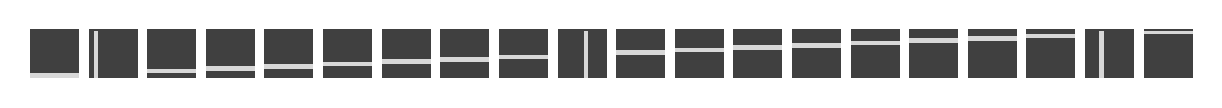

In [12]:
# set up black to grey colormap
cmap = plt.cm.gray
# crop the gray colormap to only include the black to grey range
cmap = cmap(np.linspace(0, 0.8, 256))
# create a new colormap with the cropped range
cmap = plt.cm.colors.ListedColormap(cmap)
figure, axes = plt.subplots(1, 20, figsize=(5, 3), dpi=300)
for i, ax in enumerate(axes.flatten()):
    image = upsample(spar_dm)[:, :, (i+35)*100] + upsample(omit_dm)[:, :, (i+35)*100]
    ax.matshow(image, cmap=cmap, alpha=0.75)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

In [13]:
print(spar_dm.shape)

(63, 63, 375)


### Go to settings.yml and change the TR to 0.016s to get a correct upsampling here
Yeah I know it's weird but Im lazy to change all the other code that assumes TR=1.6s

In [14]:
def predict_prf(
    subject,
    space,
    prf_data,
    prf_dm,
    prf_params_dir,
    model="norm",
    stage="iter",
    voxel_selection=None,
):
    # load in the model parameters from a pickle file
    params_tsv_name = os.path.join(
        prf_params_dir,
        f"{subject}_ses-1_final-fit_space-{space}_model-{model}_stage-{stage}_desc-prf_params.tsv",
    )

    # Define the objects for the prf fits
    prf_obj = PRFModel()
    prf_obj.get_dm(prf_dm)
    prf_obj.get_data(prf_data)
    params = pd.read_csv(params_tsv_name, sep="\t")
    prf_obj.load_params(params, model=model, stage=stage)
    prf_preds = prf_obj.make_predictions(model="norm", vox_nr=voxel_selection)
    return prf_preds

In [15]:
def set_hrf(TR, hrf_deriv, hrf_disp):
    hrf_params = [1, hrf_deriv, hrf_disp]
    hrf = np.array(
        [
            np.ones_like(hrf_params[1], dtype="float32")
            * hrf_params[0]
            * spm_hrf(tr=TR, oversampling=1, time_length=40),
            hrf_params[1] * spm_time_derivative(tr=TR, oversampling=1, time_length=40),
            hrf_params[2]
            * spm_dispersion_derivative(tr=TR, oversampling=1, time_length=40),
        ],
        dtype="float32",
    ).sum(axis=0)
    hrf /= hrf.max()
    return hrf

In [16]:
dm_fn = str(prf_dir / subject / "ses-1" / "dms" / "dm_task-pRF_run-01.npy")
design_matrix = np.load(dm_fn)
dm_guideline = design_matrix.sum((0,1))
# scale dm_guideline to 0-5
dm_guideline = 5 * (dm_guideline - dm_guideline.min()) / (dm_guideline.max() - dm_guideline.min())
dm_guideline = np.tile(dm_guideline, 3)

In [17]:
rsq = np.array(prf_pars_df['r2'])

rsq_violmodel = np.load(
    os.path.join(prf_dir, subject, "ses-1", subfolder, f"{subject}_ses-1_space-fsaverage_surprise-viol_rsq.npy")
)

TRMI = np.load(
    os.path.join(prf_dir, subject, "ses-1", subfolder, f"{subject}_ses-1_space-fsaverage_surprise-TRMI.npy")
)
beta_sparsedm = np.load(
    os.path.join(prf_dir, subject, "ses-1", subfolder, f"{subject}_ses-1_space-fsaverage_surprise-viol_beta_sparsedm.npy")
)
beta_omitdm = np.load(
    os.path.join(prf_dir, subject, "ses-1", subfolder, f"{subject}_ses-1_space-fsaverage_surprise-viol_beta_omitdm.npy")
)

In [18]:
ROIs_list_long = ('V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LO1', 'LO2', 'VO1', 
        'VO2', 'hMT', 'MST', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5')
ROIs_list_short = ["V1", "V2", "V3", "V3AB", "hV4", "LO", "TO", "VO", "IPS"]
roi_verts = cx.get_roi_verts('fsaverage', ROIs_list_long)

average rsq of V1: 0.66 
average rsq of V2: 0.64 
average rsq of V3: 0.53 
average rsq of V3A: 0.46 
average rsq of V3B: 0.47 
average rsq of V4: 0.43 
average rsq of LO1: 0.45 
average rsq of LO2: 0.36 
average rsq of VO1: 0.35 
average rsq of VO2: 0.17 
average rsq of hMT: 0.59 
average rsq of MST: 0.45 
average rsq of IPS0: 0.41 
average rsq of IPS1: 0.41 
average rsq of IPS2: 0.27 
average rsq of IPS3: 0.27 
average rsq of IPS4: 0.27 
average rsq of IPS5: 0.25 


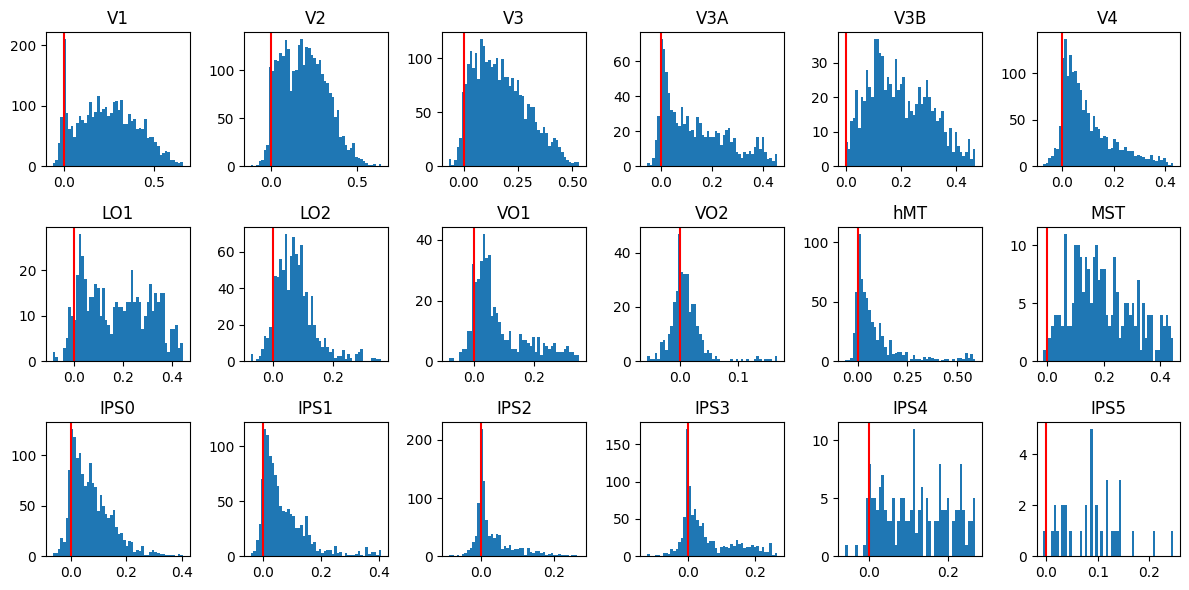

In [19]:
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.flatten()
for i, roi in enumerate(ROIs_list_long):
    print("average rsq of {}: {} ".format(roi, np.nanmax(rsq_violmodel[roi_verts[roi]]).round(2)))
    ax[i].hist(rsq_violmodel[roi_verts[roi]], bins=50)
    ax[i].set_title(roi)
    ax[i].axvline(0, color='r')
fig.tight_layout()
plt.show()
plt.close()


### Create pycortex vertex objects

In [20]:
thresh = 0.1
rsq_mask = rsq > thresh

TRMI[~rsq_mask] = np.nan
beta_sparsedm[~rsq_mask] = np.nan
beta_omitdm[~rsq_mask] = np.nan

TRMI_v = cx.Vertex2D(dim1=TRMI, dim2=rsq, subject=space,
                    cmap='PRGn_alpha', vmin=-0.3, vmax=0.3, vmin2=0, vmax2=0.5)
beta_sparsedm_v = cx.Vertex2D(dim1=beta_sparsedm, dim2=rsq, subject=space,
                    cmap='seismic_alpha', vmin=0, vmax=2, vmin2=0, vmax2=0.5)
beta_omitdm_v = cx.Vertex2D(dim1=beta_omitdm, dim2=rsq, subject=space,
                    cmap='seismic_alpha', vmin=0, vmax=2, vmin2=0, vmax2=0.5)
rsq_violmodel_v = cx.Vertex(rsq_violmodel, subject=space, cmap='inferno', vmin=0, vmax=0.5)

###################################################################################################
###################################################################################################
#######
# create pycortex vars
#######
###################################################################################################
###################################################################################################

mask, extents = cx.quickflat.utils.get_flatmask(space, height=flatmap_height)
vc = cx.quickflat.utils._make_vertex_cache(space, height=flatmap_height)

mask_index = np.zeros(mask.shape)
mask_index[mask] = np.arange(mask.sum())

### Create figures etc

In [21]:
print(np.nanmax(rsq_violmodel))
print(np.nanargmax(rsq_violmodel))
# find 10 vertices with the highest r2 values
argsorted_v = np.argsort(rsq_violmodel)[::-1]
while np.isnan(rsq_violmodel[argsorted_v[0]]):
    argsorted_v = argsorted_v[1:]
print(argsorted_v[0:10])


0.6581828263553844
170922
[170922 300837 195722 207800 277963  79676 177080 207802 277950 173273]


In [22]:
# find vetecies with a high viol_ratio and high model r2
viol_ratio_thresh = 0.15
for roi in roi_verts.keys():
    # find the vertex with the highest r2 value in each ROI, but still keep the 
    roi_argsorted_v = np.argsort(rsq_violmodel[roi_verts[roi]])[::-1]
    while (np.isnan(rsq_violmodel[roi_verts[roi]][roi_argsorted_v[0]])) or (np.abs(TRMI[roi_verts[roi]][roi_argsorted_v[0]])<viol_ratio_thresh):
        roi_argsorted_v = roi_argsorted_v[1:]
    print(f'{roi}: {roi_verts[roi][roi_argsorted_v[0]]}, glm_rsq: {rsq_violmodel[roi_verts[roi]][roi_argsorted_v[0]]:.2f}, viol_ratio: {TRMI[roi_verts[roi]][roi_argsorted_v[0]]:.2f}')

V1: 79676, glm_rsq: 0.65, viol_ratio: -0.16
V2: 46066, glm_rsq: 0.49, viol_ratio: -0.16
V3: 43672, glm_rsq: 0.44, viol_ratio: -0.15
V3A: 130302, glm_rsq: 0.42, viol_ratio: -0.23
V3B: 321786, glm_rsq: 0.47, viol_ratio: -0.17
V4: 230280, glm_rsq: 0.38, viol_ratio: -0.16
LO1: 185447, glm_rsq: 0.40, viol_ratio: -0.16
LO2: 126647, glm_rsq: 0.24, viol_ratio: -0.39
VO1: 170948, glm_rsq: 0.17, viol_ratio: 0.15
VO2: 165230, glm_rsq: 0.06, viol_ratio: 0.22
hMT: 185396, glm_rsq: 0.14, viol_ratio: 0.17
MST: 276366, glm_rsq: 0.19, viol_ratio: 0.15
IPS0: 250948, glm_rsq: 0.33, viol_ratio: -0.15
IPS1: 30036, glm_rsq: 0.26, viol_ratio: -0.22
IPS2: 86778, glm_rsq: 0.14, viol_ratio: -0.15
IPS3: 211611, glm_rsq: 0.17, viol_ratio: -0.16
IPS4: 305991, glm_rsq: 0.15, viol_ratio: -0.16
IPS5: 213973, glm_rsq: 0.13, viol_ratio: -0.26


In [23]:
best_voxel = 251134

In [24]:
prf_params_dir = str(prf_dir / subject / "ses-1"/ "prf_fits" / "prf_params")
omit_pred_hires = predict_prf(subject, space, omit_pred, upsample(omit_dm), prf_params_dir, voxel_selection=best_voxel)
spar_pred_hires = predict_prf(subject, space, spar_pred, upsample(spar_dm), prf_params_dir, voxel_selection=best_voxel)

omit_pred_hires = np.squeeze(omit_pred_hires[0])
spar_pred_hires = np.squeeze(spar_pred_hires[0])

Loading settings from /Users/dionysus/Library/CloudStorage/OneDrive-Personal/Workbench/pRF_expect_pub/pRF_expect_analysis/prf_expect/settings.yml
Inserting parameters from <class 'pandas.core.frame.DataFrame'> as 'norm_iter' in <prf_expect.utils.fit.PRFModel object at 0x137aab770>
Loading settings from /Users/dionysus/Library/CloudStorage/OneDrive-Personal/Workbench/pRF_expect_pub/pRF_expect_analysis/prf_expect/settings.yml
Inserting parameters from <class 'pandas.core.frame.DataFrame'> as 'norm_iter' in <prf_expect.utils.fit.PRFModel object at 0x143297ed0>


In [25]:
def get_hex_color(cmap_name='BrBG_r', value=None):
    cmap = plt.cm.get_cmap(cmap_name)
    norm = plt.Normalize(-0.3, 0.3)
    rgba = cmap(norm(value))
    hex_color = rgb2hex(rgba[:3])
    return hex_color

/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_2032/1269017587.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('BrBG_r')


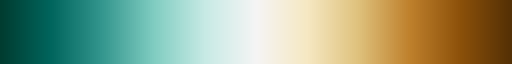

In [26]:
cmap = plt.cm.get_cmap('BrBG_r')
cmap

/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_2032/2723579929.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


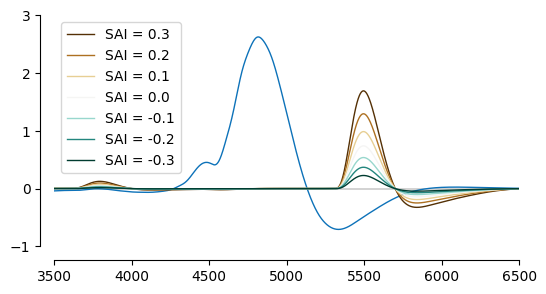

In [27]:
%matplotlib inline
timecourse_ax = plt.figure(figsize=(6, 3)).add_subplot(111)

def redraw_vertex_plots(vertex, refresh=False):
    if refresh:
        timecourse_ax.clear()
    timecourse_ax.axhline(0, color='black', lw=0.25)
    omit_pred_vertex = omit_pred_hires
    spar_pred_vertex = spar_pred_hires
    timecourse_ax.plot(omit_pred_vertex*1, color='#0D72B9', lw=1)
    for index in [0.3, 0.2, 0.1, 0, -0.1, -0.2, -0.3]:
        beta = (-index-0.5)/(index-1)
        color = get_hex_color(cmap_name='BrBG_r', value=index)
        timecourse_ax.plot(spar_pred_vertex * beta, color=color, lw=1, label='SAI = {:.1f}'.format(index))
    
    timecourse_ax.set_xlim(3500, 6500)
    timecourse_ax.set_ylim(-1, 3)
    timecourse_ax.set_yticks(range(-1, 4, 1))
    sns.despine(offset=10, ax=timecourse_ax)
    timecourse_ax.legend(loc="upper left")

    if prf_pars_df['prf_ampl'][vertex] != 0:
        pass


def zoom_to_roi(axis, space, roi, hem, margin=10.0):
    roi_verts = cx.get_roi_verts(space, roi)[roi]
    roi_map = cx.Vertex.empty(space)
    roi_map.data[roi_verts] = 1

    (lflatpts, lpolys), (rflatpts, rpolys) = cx.db.get_surf(space, "flat",
                                                            nudge=True)
    sel_pts = dict(left=lflatpts, right=rflatpts)[hem]
    roi_pts = sel_pts[np.nonzero(getattr(roi_map, hem))[0], :2]

    xmin, ymin = roi_pts.min(0) - margin
    xmax, ymax = roi_pts.max(0) + margin
    print([xmin, xmax, ymin, ymax])
    axis.axis([xmin, xmax, ymin, ymax])

    return [xmin, xmax, ymin, ymax]

redraw_vertex_plots(best_voxel)
plt.draw()
plt.show()

# save pdf
timecourse_ax.get_figure().savefig(figure_result_dir / f"{subject}_ses-1_task-pRF_space-fsaverage_desc-viol_timecourse.pdf", dpi=600, bbox_inches='tight')
plt.close('all')

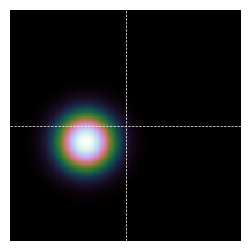

In [28]:
prf_ax = plt.figure(figsize=(3, 3)).add_subplot(111)
prf = gauss2D_iso_cart(prf_space_x,
                        prf_space_y,
                        [prf_pars_df['x'][best_voxel],
                            prf_pars_df['y'][best_voxel]],
                        prf_pars_df['prf_size'][best_voxel])
prf_ax.clear()
prf_ax.matshow(prf, extent=vf_extent+vf_extent, cmap='cubehelix')
prf_ax.axvline(0, color='white', linestyle='dashed', lw=0.5)
prf_ax.axhline(0, color='white', linestyle='dashed', lw=0.5)

prf_ax.set_xticks([])
prf_ax.set_yticks([])
plt.axis('off')
plt.show()
prf_ax.get_figure().savefig(figure_result_dir / f"{subject}_ses-1_task-pRF_space-fsaverage_desc-prf_gauss2D_iso_cart.pdf", dpi=600, bbox_inches='tight')


### And remember go back to settings.yml and change the TR back to 1.6 when you're done